# Semantic Segmentation Model Training and Evaluation

In [ ]:
!pip install segmentation-models
#!pip install tta-wrapper

In [2]:
# mount drive to access the project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_folder = "/content/drive/My Drive/w210_project"
%cd $project_folder

/content/drive/My Drive/w210_project


In [4]:
root_folder = "/content/drive/My Drive/w210_project/dataset/segmentation/"
data_folder = "/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/"
models_folder = "/content/drive/My Drive/w210_project/models/segmentation/"

## Import Packages

In [9]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import shutil

#tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import albumentations as albu
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
from albumentations import Resize

import segmentation_models as sm
from segmentation_models import Unet
#from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score


## Copy over images and masks

In [ ]:
# copy images masks from the data_folder+from_folder to the data_folder/images/ and data_folder/masks/
def copy_downloaded_images_masks(from_folder):
  images_from_path = data_folder+from_folder+"/images/"
  masks_from_path = data_folder+from_folder+"/masks/"

  images_to_path = data_folder+"/images/"
  masks_to_path = data_folder+"/masks/"

  print(images_to_path)
  print(masks_to_path)

  if not os.path.exists(images_to_path):
      os.makedirs(images_to_path)

  if not os.path.exists(masks_to_path):
      os.makedirs(masks_to_path)

  images_names = os.listdir(images_from_path)
  images_names = [images_from_path+'/'+ name for name in images_names]
  print(images_names[0])

  masks_names = os.listdir(masks_from_path)
  masks_names = [masks_from_path+'/'+ name for name in masks_names]
  print(masks_names[0])

  # copy over images
  for name in images_names:
    shutil.copy(name, images_to_path)

  for name in masks_names:
    shutil.copy(name, masks_to_path)


#copy_downloaded_images_masks("zoom21_600/")
#copy_downloaded_images_masks("zoom20_600")
#copy_downloaded_images_masks("zoom21_416/")

/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel//images/
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel//masks/
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/zoom21_600//images//ckp8tu8ed00063b69eql1lopd.png
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/zoom21_600//masks//ckp8tu8ed00063b69eql1lopd.png


In [ ]:
# list the number of images in all folders
folder = data_folder+"images/"
!ls '$folder' | wc -l

folder = data_folder+"masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom21_416/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom21_416/masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom21_600/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom21_600/masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom20_600/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom20_600/masks/"
!ls '$folder' | wc -l

466
466
113
112
177
177
178
178


In [ ]:
# split data into train, val and test folder
def create_train_val_test_folders(): 
    root_dir = root_folder # root path
    images_folder = data_folder + "images/"
    masks_folder = data_folder + "masks/"
 
    folders = ['images', 'masks']

    val_ratio = 0.15
    test_ratio = 0.05

    # get all file names under 'images' folder
    all_file_names = os.listdir(images_folder)
    np.random.shuffle(all_file_names)
    train_names, val_names, test_names = np.split(np.array(all_file_names),
                                                              [int(len(all_file_names)* (1 - (val_ratio + test_ratio))), 
                                                              int(len(all_file_names)* (1 - test_ratio))])

    train_images_names = [images_folder+'/'+ name for name in train_names.tolist()]
    val_images_names = [images_folder+'/' + name for name in val_names.tolist()]
    test_images_names = [images_folder+'/' + name for name in test_names.tolist()]

    train_masks_names = [masks_folder+'/'+ name for name in train_names.tolist()]
    val_masks_names = [masks_folder+'/' + name for name in val_names.tolist()]
    test_masks_names = [masks_folder+'/' + name for name in test_names.tolist()]

    print('Total images: ', len(all_file_names))
    print('Training: ', len(train_images_names))
    print('Validation: ', len(val_images_names))
    print('Testing: ', len(test_images_names))


    # create folders
    os.makedirs(root_dir +'train/')
    os.makedirs(root_dir +'val/')
    os.makedirs(root_dir +'test/')

    for folder in folders:
      os.makedirs(root_dir +'train/'+folder)
      os.makedirs(root_dir +'val/'+folder)
      os.makedirs(root_dir +'test/'+folder)

    # copy over images
    for name in train_images_names:
      shutil.copy(name, root_dir +'train/images/')

    for name in val_images_names:
      shutil.copy(name, root_dir +'val/images/')

    for name in test_images_names:
      shutil.copy(name, root_dir +'test/images/')

    # Copy over masks
    for name in train_masks_names:
      shutil.copy(name, root_dir +'train/masks/')

    for name in val_masks_names:
      shutil.copy(name, root_dir +'val/masks/')

    for name in test_masks_names:
      shutil.copy(name, root_dir +'test/masks/')

#create_train_val_test_folders()

Total images:  466
Training:  372
Validation:  70
Testing:  24


In [ ]:
def copy_to_train_val_test_from_specific_folder(from_folder):

#copy_to_train_val_test_from_specific_folder("zoom21_416")

## Data Generator Class

In [ ]:
IMG_SIZE = 416
BATCH_SIZE = 4

class DataGeneratorFolder(keras.utils.Sequence):
    def __init__(self, root_dir=r'./dataset/segmentation/solar_panel/', image_folder='images/', mask_folder='masks/', 
                 batch_size=BATCH_SIZE, image_size=IMG_SIZE, nb_y_features=1, 
                 augmentation=None, preprocessing= None,
                 suffle=True):
        self.images_folder = os.path.join(root_dir, image_folder)
        self.masks_folder = os.path.join(root_dir, mask_folder)
        self.image_filenames = os.listdir(os.path.join(root_dir, image_folder))        
        self.mask_names = os.listdir(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle

        #print(self.image_filenames)
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        return cv2.imread(os.path.join(self.images_folder, image_name), cv2.IMREAD_COLOR)/255, (cv2.imread(os.path.join(self.masks_folder, image_name), cv2.IMREAD_GRAYSCALE) > 0).astype(np.int8)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

        for i, sample_index in enumerate(indexes):

            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
                        
            # apply preprocessing
            if self.preprocessing:
              sample = self.preprocessing(image=X_sample, mask=y_sample)
              X_sample, y_sample = sample['image'], sample['mask']

            # if augmentation is defined, apply augmentation to X_sample, y_sample
            if self.augmentation is not None:                  
                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample, mask=y_sample)
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                y[i, ...] = mask_augm
            
            # if augmentation is not defined 
            elif self.augmentation is None:                
                # just resize the images
                augmented = Resize(height=self.image_size, width=self.image_size)(image = X_sample, mask = y_sample)
                X_sample = augmented['image'].reshape(self.image_size, self.image_size, 3)
                y_sample = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                
                X[i, ...] = X_sample
                y[i, ...] = y_sample
                
        return X, y

# Augmentation

In [ ]:
# define augmentation function
def aug_with_crop(image_size = IMG_SIZE, crop_prob = 1):
    return Compose([
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        #VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.25),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

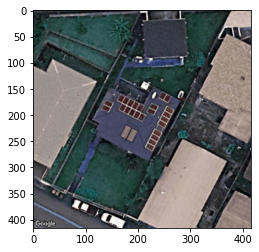

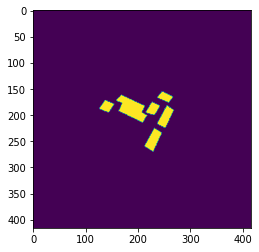

In [ ]:
# check one example of data generator
example_data_generator = DataGeneratorFolder(root_dir = root_folder+'train/',
                                     image_folder = 'images/', 
                                     mask_folder = 'masks/',
                                     batch_size = BATCH_SIZE,
                                     nb_y_features = 1, 
                                     augmentation = None)
Xtest, ytest = example_data_generator.__getitem__(5)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show()

In [ ]:
# Set up train, val, test data generators

BACKBONE = "efficientnetb7"
preprocess_input = sm.get_preprocessing(BACKBONE)

train_generator = DataGeneratorFolder(root_dir = root_folder+'train/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = aug_with_crop,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

val_generator = DataGeneratorFolder(root_dir = root_folder+'val/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = None,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

test_generator = DataGeneratorFolder(root_dir = root_folder+'test/', 
                                     image_folder = 'images/', 
                                     mask_folder = 'masks/', 
                                     augmentation = None,
                                     preprocessing = None,
                                     batch_size=1,
                                     image_size=IMG_SIZE)

In [ ]:
# set up callbacks

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,
                               verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint(models_folder+"unet_solar_segmentation_model.h5", monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, save_freq='epoch')

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=20, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./segmentation_logs/tensorboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

In [ ]:
LR = 0.0001
sm.set_framework('tf.keras')
model = Unet(backbone_name = 'efficientnetb7', encoder_weights='imagenet', encoder_freeze = False)

# define optomizer
optim = keras.optimizers.Adam(LR)
bce_jaccard_loss = sm.losses.bce_jaccard_loss
binary_crossentropy = sm.losses.binary_crossentropy
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimizer, loss and metrics
model.compile(optim, 'binary_crossentropy', metrics)

history = model.fit(train_generator, shuffle =True,
                  epochs=50, workers=4, use_multiprocessing=True,
                  validation_data = val_generator, 
                  verbose = 1, callbacks=callbacks,
                  validation_steps=len(val_generator))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
93/93 [==============================] - 117s 902ms/step - loss: 0.3802 - iou_score: 0.3963 - f1-score: 0.5272 - val_loss: 0.7323 - val_iou_score: 0.2005 - val_f1-score: 0.3251

Epoch 00001: val_iou_score improved from -inf to 0.20054, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model.h5
Epoch 2/50
93/93 [==============================] - 72s 760ms/step - loss: 0.2056 - iou_score: 0.6598 - f1-score: 0.7892 - val_loss: 0.2705 - val_iou_score: 0.6352 - val_f1-score: 0.7729

Epoch 00002: val_iou_score improved from 0.20054 to 0.63525, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model.h5
Epoch 3/50
93/93 [==============================] - 73s 762ms/step - loss: 0.1431 - iou_score: 0.7097 - f1-score: 0.8252 - val_loss: 0.1634 - val_iou_score: 0.7211 - val_f1-score: 0.8335

Epoch 00003: val_iou_score improved from 0.63525 to 0.72109, saving model to /content/drive/My Drive/w21

In [ ]:
# build and fit UNet model    
#sm.set_framework('tf.keras')
#model = Unet(backbone_name = 'efficientnetb7', encoder_weights='imagenet', encoder_freeze = False)
#model.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=[iou_score])

#history = model.fit(train_generator, shuffle =True,
#                  epochs=50, workers=4, use_multiprocessing=True,
#                  validation_data = val_generator, 
#                  verbose = 1, callbacks=callbacks)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
93/93 [==============================] - 93s 660ms/step - loss: 0.2830 - iou_score: 0.1809 - val_loss: 3.9196 - val_iou_score: 0.1796

Epoch 00001: val_iou_score improved from -inf to 0.17956, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model.h5
Epoch 2/50
93/93 [==============================] - 59s 623ms/step - loss: 0.0889 - iou_score: 0.3858 - val_loss: 0.0948 - val_iou_score: 0.3746

Epoch 00002: val_iou_score improved from 0.17956 to 0.37460, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model.h5
Epoch 3/50
93/93 [==============================] - 59s 621ms/step - loss: 0.0686 - iou_score: 0.4757 - val_loss: 0.0776 - val_iou_score: 0.4685

Epoch 00003: val_iou_score improved from 0.37460 to 0.46846, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model.h5
Epoch 4/50
93/93 [==============================] - 54s 568ms/st

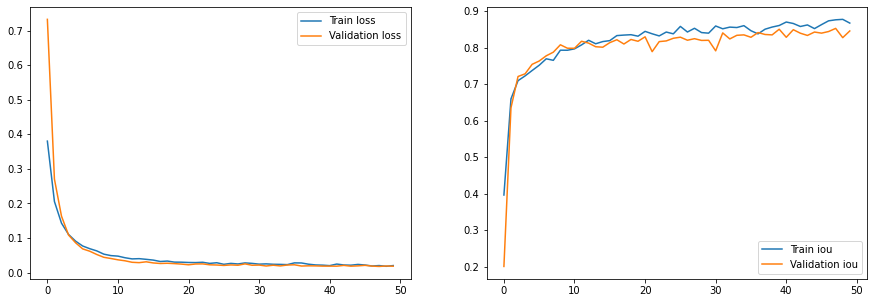

In [ ]:
# plot training history
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()

plot_training_history(history)

In [ ]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
# functions for evaluating iou metric

def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Greys")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [ ]:
from tensorflow import keras
from keras.models import load_model
import segmentation_models
from segmentation_models.metrics import IOUScore

saved_model = load_model(models_folder+'unet_solar_segmentation_model.h5',
                   custom_objects={'iou_score': IOUScore(threshold=0.5), 'f1-score': sm.metrics.FScore(threshold=0.5)})

# get single image and its prediction 
Xtest, y_test  = test_generator.__getitem__(2)
predicted = saved_model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(IMG_SIZE, IMG_SIZE)
print('IOU', iou_metric(y_test[0].reshape(IMG_SIZE, IMG_SIZE), predicted))

IOU [[0.94286817]]


In [ ]:
predicted = tf.where(predicted < 0.5, 0, 1)
print(predicted)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(416, 416), dtype=int32)


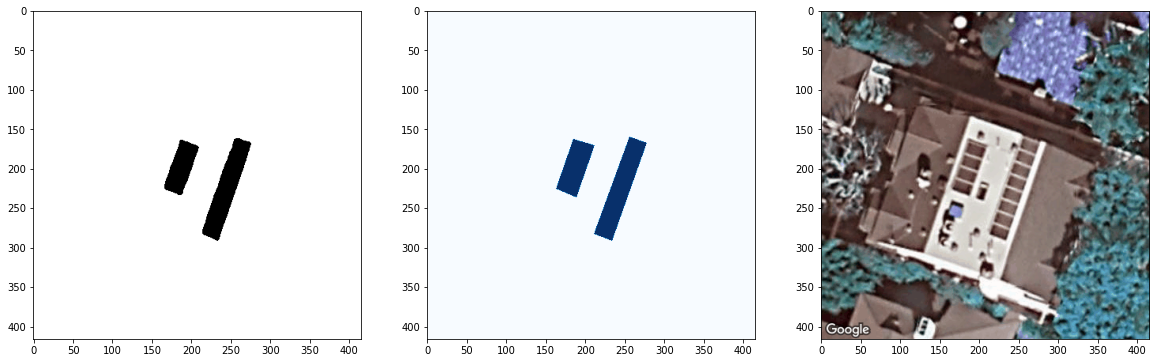

In [ ]:
plot_mask_gt_image(predicted, y_test.squeeze(0).squeeze(-1),\
           Xtest.squeeze(0))

## Test Data Evaluation

In [ ]:
preds = []
y_val = []
scores = []
for i in (range(0,test_generator.__len__())):
    Xtest, y_test  = test_generator.__getitem__(i)
    preds.append(saved_model.predict(Xtest).reshape(IMG_SIZE, IMG_SIZE))
    y_val.append(y_test)
    score = saved_model.evaluate(Xtest, y_test)
    scores.append(score)

preds = np.stack(preds, axis=0)
y_val = np.stack(y_val, axis=0)

mean_iou = iou_metric_batch(y_val, preds)
print("Mean IOU: {}".format(mean_iou))

metrics=[iou_score]
print(scores)

1/1 [==============================] - 0s 64ms/step - loss: 0.0051 - iou_score: 0.9140 - f1-score: 0.9551
Mean IOU: 0.850836229899655
[[0.00824267789721489, 0.8827745914459229, 0.9377379417419434], [0.012820427305996418, 0.6379061341285706, 0.778928816318512], [0.005139280576258898, 0.942868173122406, 0.9705941081047058], [0.013535195030272007, 0.8921793103218079, 0.9430177211761475], [0.015911096706986427, 0.6728196740150452, 0.8044138550758362], [0.0030223913490772247, 0.9058296084403992, 0.9505882263183594], [0.002625743392854929, 0.7622149586677551, 0.8650646805763245], [0.005033204331994057, 0.9614337682723999, 0.9803377389907837], [0.012450926005840302, 0.9315323233604431, 0.964552640914917], [0.005903693847358227, 0.9406563639640808, 0.969420850276947], [0.014443972148001194, 0.7596175670623779, 0.8633893728256226], [0.010610673576593399, 0.8933888077735901, 0.9436929225921631], [0.006052103359252214, 0.9057910442352295, 0.9505670070648193], [0.013391062617301941, 0.888355612754

In [ ]:
#print("Loss: {:.5}".format(np.mean(scores[:,0])))
#for metric, value in zip(metrics, np.mean(scores[:, 1]) ):
#    print("mean {}: {:.5}".format(metric.__name__, value))

# Adjust threshold

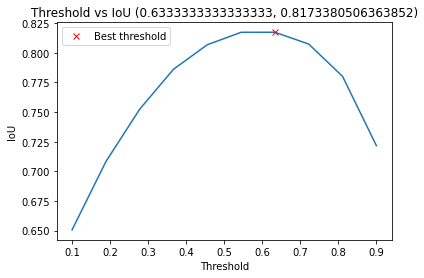

In [ ]:
def draw_get_best_threshold(ious, thresholds):
    """
    Returns threshold_best, iou_best
    """
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    return threshold_best, iou_best

preds = []
y_val = []
for i in (range(0,test_generator.__len__())):
    Xtest, y_test  = test_generator.__getitem__(i)
    preds.append(loaded_model.predict(Xtest).reshape(IMG_SIZE, IMG_SIZE))
    y_val.append(y_test)
preds = np.stack(preds, axis=0)
y_val = np.stack(y_val, axis=0)

thresholds = list(np.linspace(0.1, 0.9, 10))
ious = np.array([iou_metric_batch(y_val, np.int32(preds > threshold)) for threshold in (thresholds)])

best_threshold, best_iou = draw_get_best_threshold(ious, thresholds)

## Test real examples

In [ ]:
from tensorflow import keras
from keras.models import load_model
import segmentation_models as sm
from segmentation_models.metrics import IOUScore
import matplotlib.pyplot as plt

saved_model = load_model(models_folder+'unet_solar_segmentation_model.h5',
                   custom_objects={'iou_score': IOUScore(threshold=0.5), 'f1-score': sm.metrics.FScore(threshold=0.5)})

In [51]:
IMG_SIZE = 416
i = 0

test_filenames = glob.glob(root_folder+'./test_examples/*')
batch_size = len(test_filenames)
X = np.empty((batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for image in test_filenames:
  test_image = cv2.imread(image, cv2.IMREAD_COLOR)/255
  resized = cv2.resize(test_image, (IMG_SIZE, IMG_SIZE))
  X_sample = resized.reshape(IMG_SIZE, IMG_SIZE, 3)
                
  X[i, ...] = X_sample
  i = i+1

predicted = (saved_model.predict(X))
for i in range(0, len(predicted)):
    predicted[i] = tf.where(predicted[i] < 0.5, 0, 1)

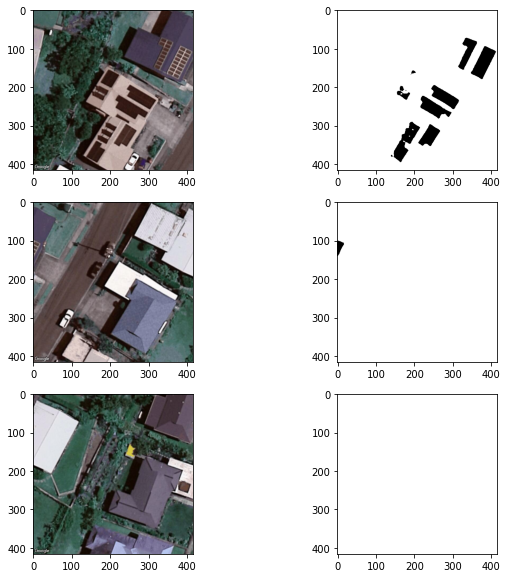

In [52]:
fig, axs = plt.subplots(3, 2, figsize=(10,10))
for i in range(0, len(X)):
  axs[i][0].imshow(X[i])
  axs[i][1].imshow(predicted[i].reshape(IMG_SIZE, IMG_SIZE), cmap="Greys")
